In [1]:
from datasetcontroller.datacontroller import DataController
import os
import tensorflow as tf
from nnmodules.gan import Generator, Discriminator, GAN
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


* 데이터셋

In [2]:
# 데이터셋 폴더 경로 설정
path = os.path.join("/workspace")
data_path = os.path.join(path,'cmaqProjectdata')

# 모델 체크포인트
proj_path = os.path.join(path,'repos','cmaqProject')
checkpoint_dir = os.path.join(proj_path,'models','training_checkpoints',"model_conmat_cmaq_1_checkpoint")
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# 컨트롤러
datacontroller = DataController(data_path = data_path)

# 기본 control matrix, smoke, cmaq 데이터셋 
control_matrix, smoke_arr, target_arr = datacontroller.get_yearly_dataset()


/usr/local/lib/python3.8/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


67 82


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3460: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/workspace/repos/cmaqProject/experiment/datasetcontroller/datacontroller.py:45: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:5179 +type=crs
Right CRS: EPSG:5179

  joined = gpd.sjoin(ctp_rvn_gpd, grid_data.to_crs(5179), op='contains')


* 제너레이터 생성 및 점검

2023-05-25 06:10:46.346238: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 06:10:48.263681: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22275 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6
2023-05-25 06:10:48.264264: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 19043 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2023-05-25 06:10:48.264712: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localho

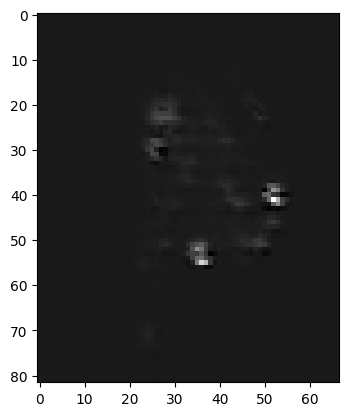

In [3]:
base_smoke = smoke_arr[0]
generator = Generator(base_smoke)
noise = tf.random.normal([1, 100 + 119])  ## 여기서 119는 컨트롤매트릭스차원
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0][::-1], cmap='gray')

* 디스크리미네이터 생성 및 점검

In [4]:
discriminator = Discriminator()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.0142109]], shape=(1, 1), dtype=float32)


* 학습

In [5]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
gan = GAN(base_smoke, lambda_c=100)
gan.compile()


checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 gan = gan,
                                 )

####### 저장된 모델 있을 경우 ##########
# manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)
# checkpoint.restore(manager.latest_checkpoint)


# 체크용 시드 고정
noise_dim = 100
num_examples_to_generate = 16

# 베이스시드로 고정 (시나리오1의 컨트롤 매트릭스 + 노이즈로 구성)
noise_std = 0.3

noise = tf.random.normal([num_examples_to_generate, noise_dim],mean = 1, stddev = noise_std)
base_senario = tf.random.normal([num_examples_to_generate, 119])
base_senario = tf.ones_like(base_senario)
seed = tf.concat([noise, base_senario], axis = 1)

# 파라미터
batch_size = 8
shuffle_buffer_size = 120
epoch = 500
# 학습용 데이터셋
input_ds = tf.data.Dataset.from_tensor_slices(control_matrix)
target_ds = tf.data.Dataset.from_tensor_slices(target_arr)
smoke_ds = tf.data.Dataset.from_tensor_slices(smoke_arr)

ds = tf.data.Dataset.zip((input_ds, smoke_ds, target_ds)).batch(batch_size).shuffle(shuffle_buffer_size)

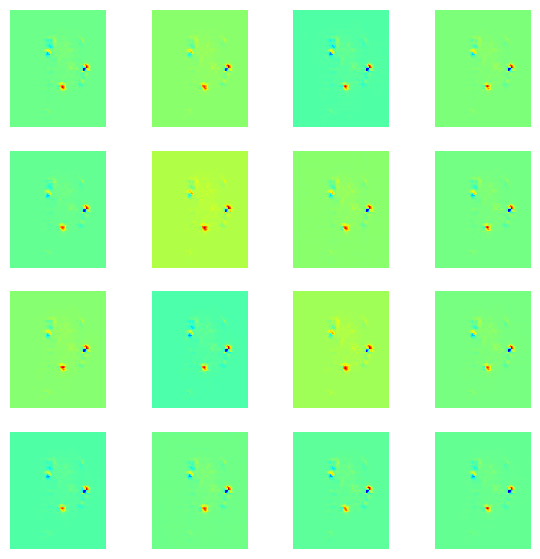

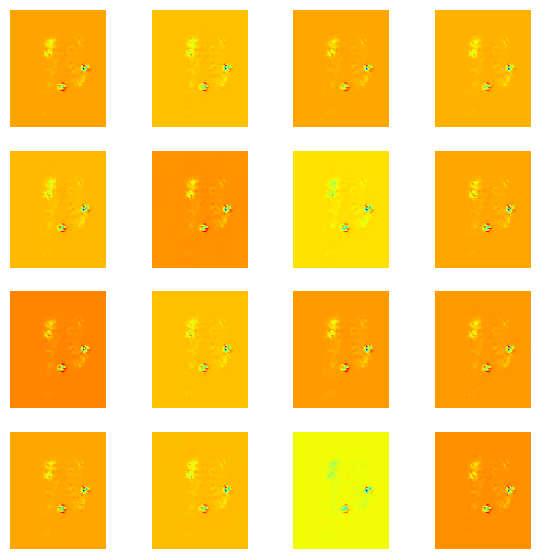

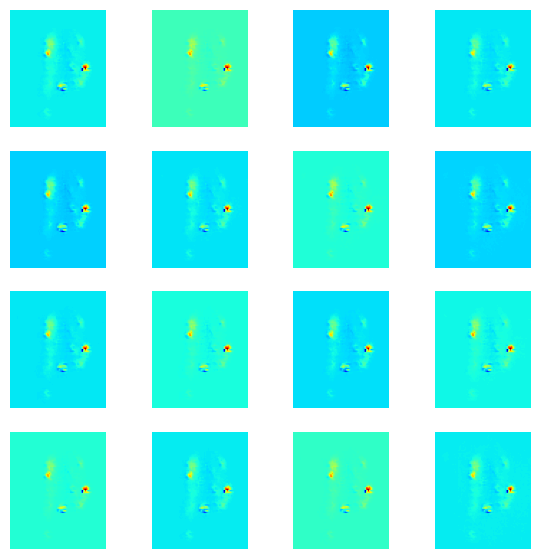

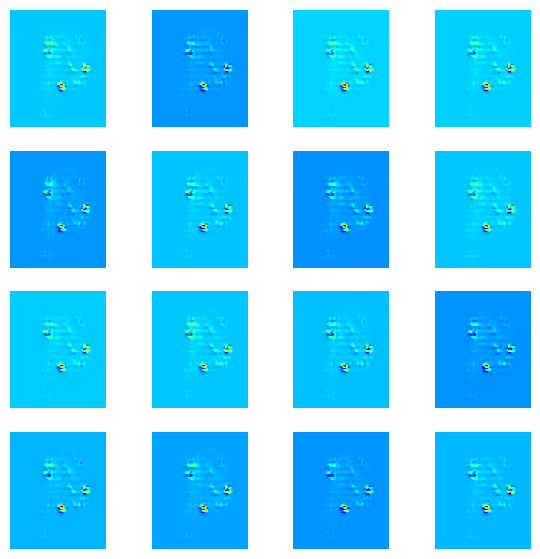

In [6]:
@tf.function
def train_step(images, conditional_input, batch_size):
    noise = tf.random.normal([batch_size, noise_dim],mean = 1, stddev = noise_std)

    noised_input = tf.concat([noise, tf.cast(conditional_input, tf.float32)], axis = 1)
    

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noised_input, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = gan.generator_loss(fake_output, generated_images, images)
      disc_loss = gan.discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


gen_loss_list, disc_loss_list = gan.train(ds, epoch, train_step, checkpoint, checkpoint_prefix, seed, batch_size)